# FDA Drug adverse event reports

In the previous notebook we have created a dataset (`selection.csv`) with a recordsselection of serious adverse effects of the top 5 Multiple Sclerosis drugs reported in the United States among patients aged 55 and above. In this second notebook we focus on the analysis of that selection. 

### Analysis using ML

First we import all the necessary libraries:

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from scipy.stats import zscore

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import shap

pd.set_option('display.max_columns', None)

D:\anaconda3\envs\datas\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We load the dataset as a panda's DataFrame

In [2]:
df = pd.read_csv("selection.csv")

### Preparing the dataset for the training process

We are going to add a column with random numbers between 0 and 1 to compare later on the importance of this random feature to predict if there are going to be adverse events with the importance of other columns of the dataframe.

In [3]:
df["random"] = np.random.rand(len(df))

In [4]:
df.sample(5)

,reactionoutcome,patient.patientweight,patient.patientonsetage,patient.patientsex,drugseparatedosagenumb,drugintervaldosageunitnumb,n_drug,actiondrug,openfda.brand_name,serious,random
682,3,54.480,55,2,1.0,6,6,unknown,OCREVUS,1,0.057247
138,2,99.880,60,2,1.0,2,13,unknown,OCREVUS,1,0.990020
361,1,90.800,55,2,1.0,6,2,na,OCREVUS,0,0.145836
274,2,78.996,55,2,1.0,2,7,reduced,OCREVUS,1,0.852804
428,6,61.744,62,2,1.0,6,4,unknown,OCREVUS,1,0.251937


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 980 entries, 0 to 979
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   reactionoutcome             980 non-null    int64  
 1   patient.patientweight       980 non-null    float64
 2   patient.patientonsetage     980 non-null    int64  
 3   patient.patientsex          980 non-null    int64  
 4   drugseparatedosagenumb      980 non-null    float64
 5   drugintervaldosageunitnumb  980 non-null    int64  
 6   n_drug                      980 non-null    int64  
 7   actiondrug                  980 non-null    object 
 8   openfda.brand_name          980 non-null    object 
 9   serious                     980 non-null    int64  
 10  random                      980 non-null    float64
dtypes: float64(3), int64(6), object(2)
memory usage: 84.3+ KB


As a first step we will divide the dataset between the dependent and independent vatiables. The oucome is the column `serious`

In [6]:
y = df["serious"]
X = df.drop(columns=["serious"])

We will check the correlation between the numerical values just in case there are any of those that are highly correlated, so we can exclude them to avoid issues related to degeneration.

After checking, we do not find any highly correlated features.

In [7]:
corr_matrix = X.corr().abs()
corr_matrix

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
print(to_drop)

[]


The next step is to create a process to modify the features of the dataframe. For the categorical variables we will create numerical columns for each category, filled with 0's and 1's. For the numerical values we scale them using a MinMaxScaler.

In [8]:
numerical_ix = X.select_dtypes(include=['int64', 'float64']).columns
categorical_ix = X.select_dtypes(include=['object']).columns
# define the data preparation for the columns
t = [('cat', OneHotEncoder(), categorical_ix), 
     ('num', MinMaxScaler(), numerical_ix)]
col_transform = ColumnTransformer(transformers=t)

Now we divide the dataset between train and test samples, but we still need to preprocess the data in the train subsample. This is to avoid data leakage.

In [9]:
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

We apply the previous column transformer and we check if there are outliers in the train sample using the Z score (with a threshold of 3). Luckily, there are no data points that are needed to be discarded as outliers based on this criteria.

In [10]:
X_train = col_transform.fit_transform(X_train_raw)
X_test = col_transform.transform(X_test_raw)
X_train = pd.DataFrame(X_train, columns=col_transform.get_feature_names_out())
X_test = pd.DataFrame(X_test, columns=col_transform.get_feature_names_out())

not_outliers = (np.abs(zscore(X_train)) < 3).any(axis=1)
print(f"Outliers = {sum(~not_outliers)}")
if sum(~not_outliers) > 0:
    X_train = pd.DataFrame(X_train)[not_outliers]
    y_train = y_train[not_outliers.values]

Outliers = 0


### Random forest modelling with all the features

The model used in this exercise is going to be a Random Forest, as we want to assess more complex relations than linear relations between the features and the outcome. 

As this is an unbalanced dataset, we need to take into account this to avoid poor performance of the model. Among all the possibilities, here we are going to upsample the class that has less datapoint using SMOTE.

For the cross validation to choose the best parapeters of the Random Forest we are going to use the repeated stratified K-Fold.

In [11]:
model = RandomForestClassifier(random_state=42)
crosval = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)

pipeline = Pipeline(
    steps=[('oversampling', SMOTE()), ('model', model)])

param_grid = {
    'model__max_depth':[3,5,10,None],
    'model__n_estimators':[10,25,50,100,150],
    'model__max_features':[5,10,15]
}

grid = GridSearchCV(pipeline,param_grid, n_jobs=-1, cv=crosval,verbose=1,scoring='f1',error_score=0)

In [12]:
grid.fit(X_train, y_train)

Fitting 15 folds for each of 60 candidates, totalling 900 fits


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=42),
             error_score=0,
             estimator=Pipeline(steps=[('oversampling', SMOTE()),
                                       ('model',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__max_depth': [3, 5, 10, None],
                         'model__max_features': [5, 10, 15],
                         'model__n_estimators': [10, 25, 50, 100, 150]},
             scoring='f1', verbose=1)

The summary of the results of the random forest model using the test dataset can be found below:

In [13]:
y_pred = grid.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.97      0.80      0.88        44
           1       0.94      0.99      0.97       152

    accuracy                           0.95       196
   macro avg       0.96      0.89      0.92       196
weighted avg       0.95      0.95      0.95       196



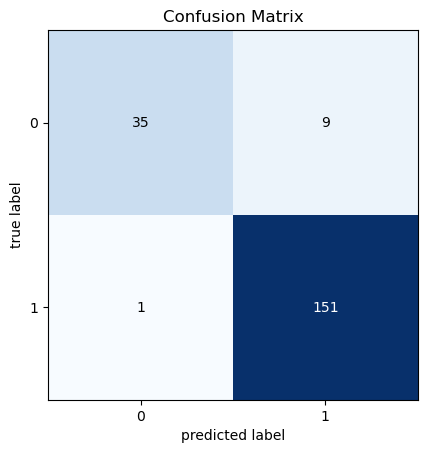

In [14]:
plot_confusion_matrix(confusion_matrix(y_test,y_pred))
plt.title(f"Confusion Matrix")
plt.show()

In [15]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.97      0.80      0.88        44
           1       0.94      0.99      0.97       152

    accuracy                           0.95       196
   macro avg       0.96      0.89      0.92       196
weighted avg       0.95      0.95      0.95       196



The results of this model are satisfactory, with F1 score above 0.8 and the recall of the class that has less datapoints is also above 0.8.

### Selecting the relevant features

Now we are going to check which features are actually contributing and which are not important. To do so we use the feature importance values from the Random Forest class and compare those values with the importance of the feature with random vaues we added at the begining of this notebook.

In [16]:
s = pd.Series(
    grid.best_estimator_._final_estimator.feature_importances_,
    index=X_test.columns
)

In [17]:
s.sort_values(ascending=False)

num__patient.patientweight                                     0.237702
num__n_drug                                                    0.212984
num__patient.patientonsetage                                   0.171163
num__drugintervaldosageunitnumb                                0.078407
num__random                                                    0.057861
num__reactionoutcome                                           0.056914
cat__actiondrug_unknown                                        0.034480
num__patient.patientsex                                        0.029439
cat__actiondrug_increased                                      0.025605
cat__openfda.brand_name_AUBAGIO                                0.019881
cat__openfda.brand_name_OCREVUS                                0.014906
cat__actiondrug_reduced                                        0.014734
num__drugseparatedosagenumb                                    0.014248
cat__openfda.brand_name_AUBAGIO,TERIFLUNOMIDE                  0

We can observe that only 4 features are actually contributing more than the random feature, that are:
- Patient weight 
- Number of drugs that the patient is taking 
- Age of the patient 
- Dosage of the drug

### Final Random Forestmodel training using the relevant feature

Given this insights, we are going to retraim the Random Forest model, but only with the features that we've found that are actually useful.

In [18]:
Xr = X[["patient.patientweight","n_drug","patient.patientonsetage","drugintervaldosageunitnumb"]]

X_train_raw, X_test_raw, y_train, y_test = train_test_split(Xr, y, test_size=0.2, random_state=42)

numerical_ix = ["patient.patientweight","n_drug","patient.patientonsetage","drugintervaldosageunitnumb"]

# define the data preparation for the columns
t = [('num', MinMaxScaler(), numerical_ix)]
col_transform = ColumnTransformer(transformers=t)

X_train = col_transform.fit_transform(X_train_raw)
X_test = col_transform.transform(X_test_raw)

X_train = pd.DataFrame(X_train, columns=col_transform.get_feature_names_out())
X_test = pd.DataFrame(X_test, columns=col_transform.get_feature_names_out())

not_outliers = (np.abs(zscore(X_train)) < 3).any(axis=1)
print(f"Outliers = {sum(~not_outliers)}")
if sum(~not_outliers) > 0:
    X_train = pd.DataFrame(X_train)[not_outliers]
    y_train = y_train[not_outliers.values]

model = RandomForestClassifier(random_state=42)
crosval = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)


pipeline = Pipeline(
    steps=[
        ('oversampling', SMOTE()), 
        ('model', model)
    ])


param_grid = {
    'model__max_depth':[3,5,10,None],
    'model__n_estimators':[10,25,50,100,150],
    'model__max_features':[1,2,3,4,5]
}

grid2 = GridSearchCV(pipeline,param_grid, n_jobs=-1, cv=crosval,verbose=1,scoring='f1',error_score=0)

Outliers = 0


In [19]:
grid2.fit(X_train, y_train)

Fitting 15 folds for each of 100 candidates, totalling 1500 fits


GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=3, n_splits=5, random_state=42),
             error_score=0,
             estimator=Pipeline(steps=[('oversampling', SMOTE()),
                                       ('model',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__max_depth': [3, 5, 10, None],
                         'model__max_features': [1, 2, 3, 4, 5],
                         'model__n_estimators': [10, 25, 50, 100, 150]},
             scoring='f1', verbose=1)

The results of this second Random Forest model are similar to the previous one, even though we only used 4 features.

In [20]:
y_pred=grid2.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.95      0.84      0.89        44
           1       0.96      0.99      0.97       152

    accuracy                           0.95       196
   macro avg       0.95      0.91      0.93       196
weighted avg       0.95      0.95      0.95       196



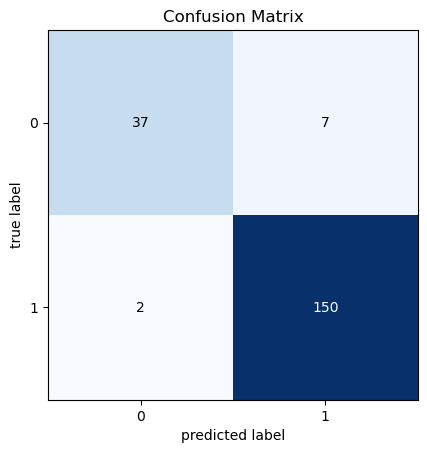

In [21]:
plot_confusion_matrix(confusion_matrix(y_test,y_pred))
plt.title(f"Confusion Matrix")
plt.show()

### Final insights

Finally we are going to obtain the insights about what factors are determinant for a senior patient with MS to suffer serious adverse effects based on the data we gathered. To do so we are going to use SHAP values.

In [22]:
# Fits the explainer
explainer = shap.Explainer(grid2.predict, X_test)
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test)

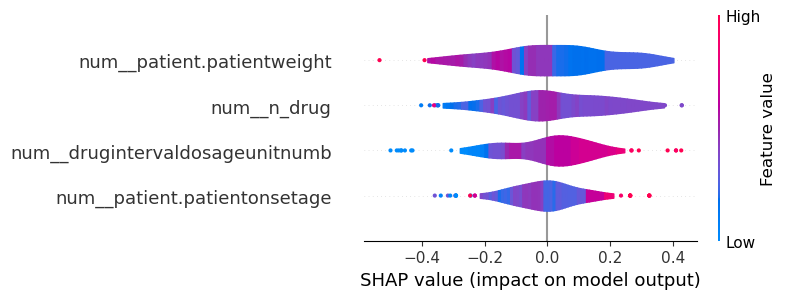

In [23]:
shap.summary_plot(shap_values, plot_type='violin')

The violin plot represents the density of values of the test sample data. The colors vary from blue to red, representing the feature values from low numbers to high values, respectively. The SHAP values provide an indication of the influence of each point on the outcome, in this case that the patient suffers serious adverse effects. Positive SHAP values indicate that a specific feature value increases the likelihood to suffer serious adverse effects, and positive values indicate the opposite.

This specific analysis allows to obtain the following insights:
- Less variety of drugs is found to be related with less likelihood of suffering serious adverse effects. Nevertheless, there are some values around -0.2 SHAP data points with high numbers of drugs that are less related to serious adverse effects.
- Patient weight is anticorrelated with suffering serious adverse effects for the MS drugs analyzed in this project.
- Increasing dosage increases the likelihood of suffering serious adverse effects.
- Lastly, the patient age is found to be a bit more complex, but it seems that overall older patients are more likely to suffer serious adverse effects.
